<a href="https://colab.research.google.com/github/tiago121/health_insurance_classification_project/blob/main/Health_insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Health Insurance Cross Sell

## 0.0 Initial considerations

### 0.1 Imports

In [ ]:
import numpy  as np
import pandas as pd
import boruta as bt
import scikitplot as skplt
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing   as pp
from sklearn import linear_model    as lm
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh

### 0.2 Helper functions

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

## 1.0 Data Description

In [ ]:
df1 = pd.read_csv('/content/health_insurance.csv')
df1 = df1.rename(columns=str.lower)
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [ ]:


aux1 = df1['gender']
aux2 = df1['vehicle_damage']
aux3 = df1['vehicle_age']
aux4 = df1['policy_sales_channel']

list = [aux1 , aux2 , aux3, aux4 ]

for i in list:
    df1_counts = i.value_counts(normalize=True)
    display(df1_counts)




Male      0.540761
Female    0.459239
Name: gender, dtype: float64

Yes    0.504877
No     0.495123
Name: vehicle_damage, dtype: float64

1-2 Year     0.525613
< 1 Year     0.432385
> 2 Years    0.042001
Name: vehicle_age, dtype: float64

152.0    0.353663
26.0     0.209127
124.0    0.194157
160.0    0.057146
156.0    0.027974
           ...   
149.0    0.000003
43.0     0.000003
144.0    0.000003
143.0    0.000003
41.0     0.000003
Name: policy_sales_channel, Length: 155, dtype: float64

### 1.1 Check NA / Duplicates

In [ ]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

In [ ]:
print(f"df has {df.duplicated().sum()} duplicated data")

df has 0 duplicated data


### 1.2 Informações colhidas com descrição

1. Não há dados faltantes
2. Age tem dados como float
3. Não há variáveis textos
4. Encodar gender para 0 e 1
5. Encodar Vehicle_Age e Vehicle_Damage

## 2.0 Feature Engineering

In [ ]:
df2 = df1.copy()

# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_Year' )

##3.0 EDA (Exploratory Data Analysis) 

In [ ]:
df3 = df2.copy()
num_attributes = df3.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df3.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [ ]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,vehicle_damage,0.0,1.0,1.0,0.504877,1.0,0.499976,-1.950724e-02,-1.999630
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
8,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
9,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


In [ ]:
#num_var = ["age", "annual_premium", "vintage"]
#cat_var = ["gender", "region_code", "previously_insured", "vehicle_age", "vehicle_damage","policy_sales_channel" ]
#target = "response"

### 3.1 Univariate Analysis

#### 3.1.1 Age

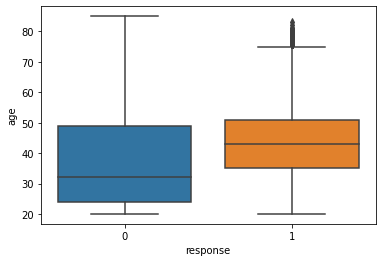

In [ ]:
sns.boxplot( x='response', y='age', data=df3 )


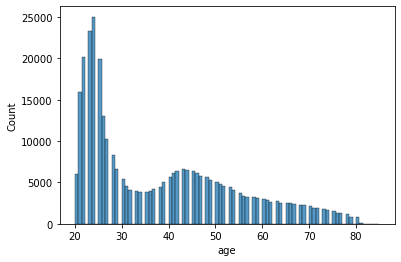

In [ ]:
aux00 = df3.loc[df3['response'] == 0, 'age']
sns.histplot( aux00 )

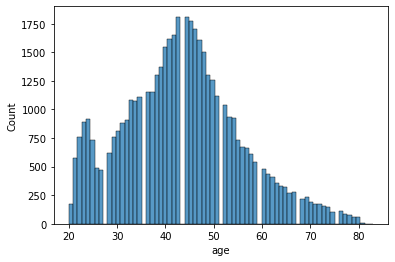

In [ ]:
aux00 = df3.loc[df3['response'] == 1, 'age']
sns.histplot( aux00 )

#### 3.1.2 Anual Income

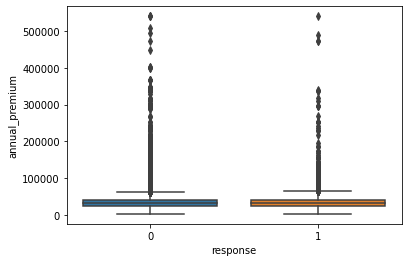

In [ ]:
sns.boxplot( x='response', y='annual_premium', data=df3 )

In [ ]:
df3 = df3[(df3['annual_premium'] > 10000) & (df3['annual_premium'] < 100000)]

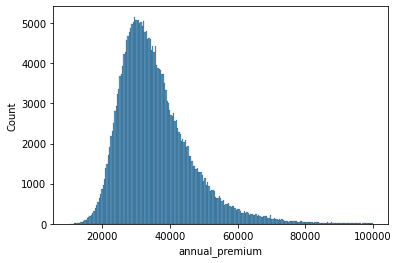

In [ ]:
aux00 = df3.loc[df3['response'] == 0, 'annual_premium']
sns.histplot( aux00 )

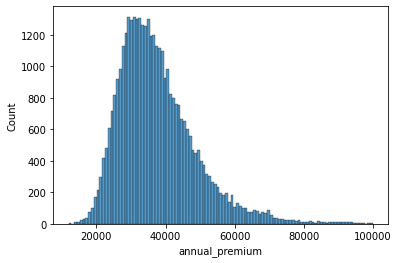

In [ ]:
aux00 = df3.loc[df3['response'] == 1, 'annual_premium']
sns.histplot( aux00 )

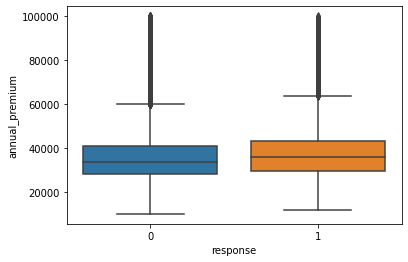

In [ ]:
sns.boxplot( x='response', y='annual_premium', data=df3 )

#### 3.1.3 Driving License

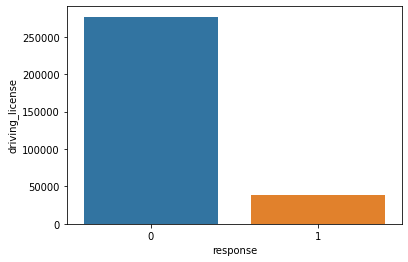

In [ ]:
aux = df3[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux )

#### 3.1.4 Region Code

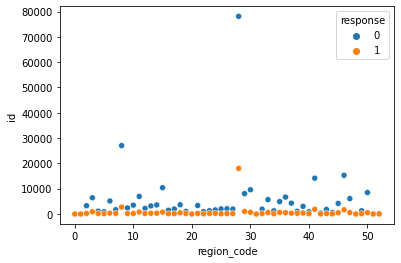

In [ ]:
aux0 = df3[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

#### 3.1.5 Previously Insured

In [ ]:
pd.crosstab(df3['previously_insured'], df3['response'] ).apply( lambda x: x / x.sum(), axis=1 )


response,0,1
previously_insured,,
0,0.769438,0.230562
1,0.999191,0.000809


#### 3.1.6 Vehicle Age

In [ ]:
df3[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()


,vehicle_age,response,id
0,below_1_Year,0,137861
1,below_1_Year,1,5994
2,between_1_2_year,0,130381
3,between_1_2_year,1,28017
4,over_2_years,0,9126
5,over_2_years,1,4070


#### 3.1.7 Vehicle Damage

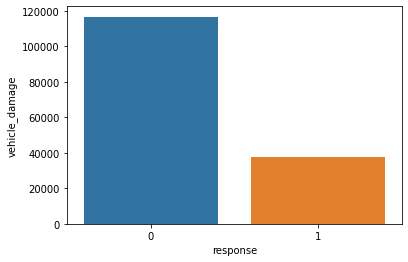

In [ ]:
aux = df3[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux );

#### 3.1.8 Policy Sales Channel 


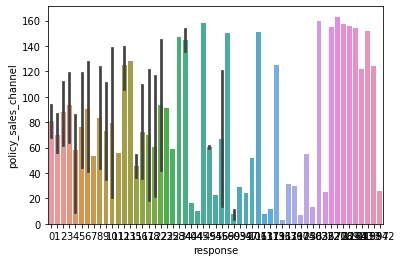

In [ ]:
aux = df3[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

In [ ]:
aux01 = df3[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
aux02 = df3[['id', 'policy_sales_channel']].groupby( 'policy_sales_channel' ).size().reset_index().rename( columns={0:'total_responses'})

aux = pd.merge( aux01, aux02, how='inner', on='policy_sales_channel' )
aux

,policy_sales_channel,response,total_responses
0,1.0,0,10
1,2.0,0,1
2,3.0,136,434
3,4.0,90,442
4,6.0,0,2
...,...,...,...
143,157.0,706,2353
144,158.0,45,148
145,159.0,1,21
146,160.0,303,16225


#### 3.1.9 Vintage

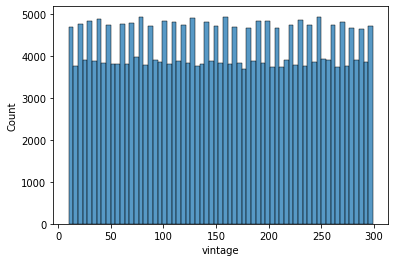

In [ ]:
aux = df3.loc[df3['response'] == 0, 'vintage']
sns.histplot( aux )

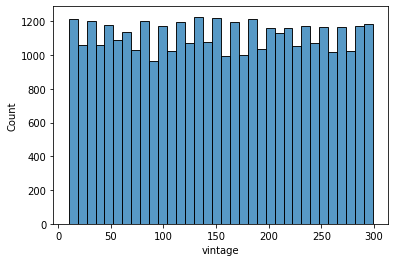

In [ ]:
aux = df3.loc[df3['response'] == 1, 'vintage']
sns.histplot( aux )

In [ ]:
df = pd.pivot_table( index='vintage', columns='response', values='id', data=df3).reset_index()
df.columns = ['vintage', 'no_response', 'yes_response']

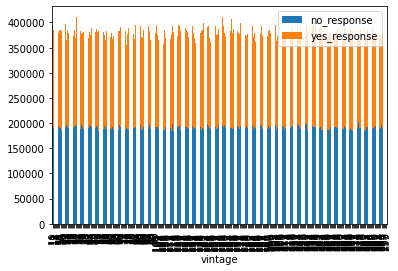

In [ ]:
df.plot( x='vintage', kind='bar', stacked=True)

### 3.2  Insights

## 4.0 Data Preparation



In [ ]:
X = df3.drop( 'response', axis=1 )
y = df3['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.99 )

df4 = pd.concat( [x_train, y_train], axis=1 )

### 4.1 Standardization

In [ ]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
df4['annual_premium'] = ss.fit_transform( df4[['annual_premium']].values )


### 4.2. Reescaling

In [ ]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df4['age'] = mms_age.fit_transform( df4[['age']].values )


# Vintage - MinMaxScaler
df4['vintage'] = mms_vintage.fit_transform( df4[['vintage']].values )


### 4.3 Encoding

In [ ]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df4.groupby( 'gender' )['response'].mean()
df4.loc[:, 'gender'] = df4['gender'].map( target_encode_gender )


# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df4.groupby( 'region_code' )['response'].mean()
df4.loc[:, 'region_code'] = df4['region_code'].map( target_encode_region_code )

# vehicle_age - One Hot Encoding / Frequency Encoding
df4 = pd.get_dummies( df4, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df4.groupby( 'policy_sales_channel' ).size() / len( df4 ) 
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map( fe_policy_sales_channel )


### 4.4 Validation Preparation

In [ ]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

## 5.0 Feature Selection

In [ ]:
df5 = df4.copy()

In [ ]:
x_train_n = df5.drop( ['id', 'response'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Define model
et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define boruta
boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	3
Rejected: 	8
Iteration:

In [ ]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = df5.drop( ['id', 'response'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta
# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

['age', 'vehicle_damage']

In [ ]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                annual_premium    0.203461
0                       vintage    0.199863
0                           age    0.191599
0                   region_code    0.120327
0          policy_sales_channel    0.097579
0                vehicle_damage    0.072460
0            previously_insured    0.057387
0                        gender    0.022673
0      vehicle_age_below_1_Year    0.014792
0      vehicle_age_over_2_years    0.010203
0  vehicle_age_between_1_2_year    0.007716
0               driving_license    0.001942


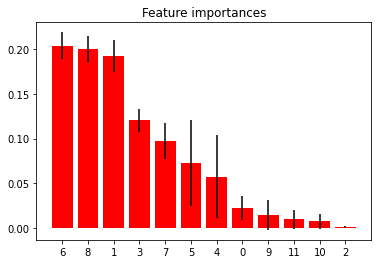

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 6.0 Machine Learning Modelling


In [ ]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 
                 'vehicle_damage','previously_insured']

In [ ]:
x_train = df5[ cols_selected ]

x_val = x_validation[ cols_selected ]
y_val = y_validation

### 6.1 KNN Classifier


In [ ]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

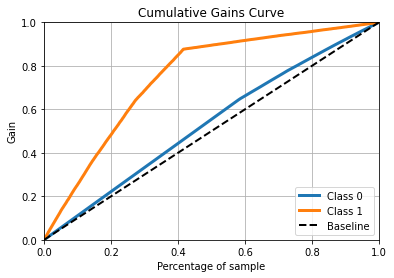

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

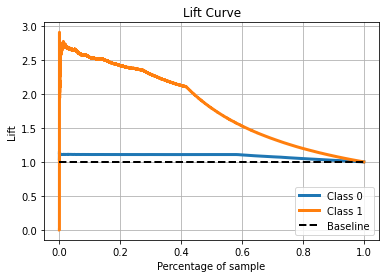

In [ ]:
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

### 6.2 Logistic Regression

In [ ]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

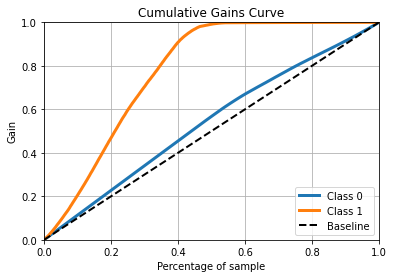

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

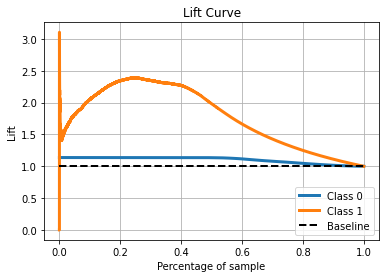

In [ ]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

### 6.3 Extra Trees Classifier

In [ ]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# model training
et.fit( x_train, y_train )

# model prediction
yhat_et = et.predict_proba( x_val )

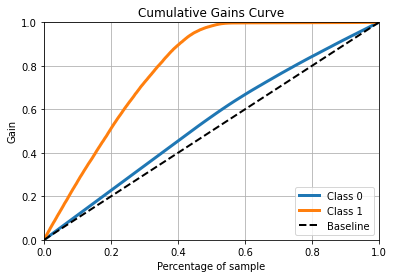

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

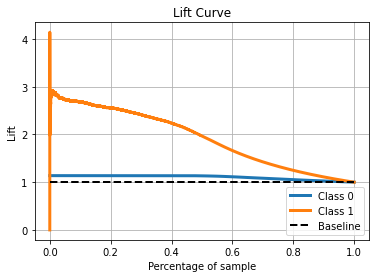

In [ ]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_et );

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
#teste = metrics.roc_auc_score(y_val, yhat_et)
#teste

ValueError: ignored

### 6.4 Random Forest

In [ ]:
# model definition
rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = et.predict_proba( x_val )

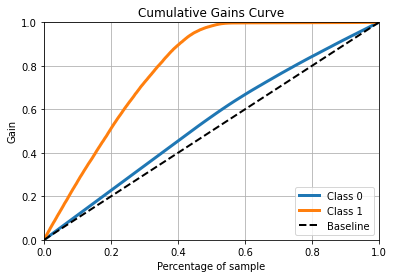

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );

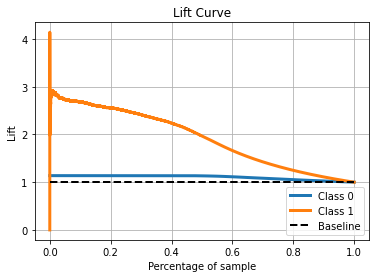

In [ ]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

###6.5 Model Selection

## 7.0 Performance Metrics

### 7.1 ROI 

In [ ]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

In [ ]:
# Compute bucket
results['bucket'] = results['prediction'].apply( lambda x: 0.9 if x >= 0.90 else 
                                                           0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
                                                           0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
                                                           0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
                                                           0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
                                                           0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
                                                           0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
                                                           0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
                                                           0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01 )

#  Aggregate clients among buckets
df = results[['prediction','bucket']].groupby( 'bucket' ).agg( {'min', 'count'} ).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

df['base'] = df['clients'].sort_values( ascending=True ).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values( 'index', ascending=False )
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
9,0.90,0.901,42,1513.68,3.604,1.000000,1510.076
8,0.80,0.800,368,11776.00,3.200,0.799822,11772.800
7,0.70,0.700,1345,37660.00,2.800,0.622084,37657.200
6,0.60,0.600,3436,82464.00,2.400,0.466563,82461.600
5,0.50,0.500,7184,143680.00,2.000,0.333259,143678.000
4,0.40,0.400,13939,223024.00,1.600,0.222173,223022.400
3,0.30,0.300,23710,284520.00,1.200,0.133304,284518.800
2,0.20,0.200,33448,267584.00,0.800,0.066652,267583.200
1,0.10,0.100,38396,153584.00,0.400,0.022217,153583.600
0,0.01,0.000,190427,0.00,0.000,0.000000,0.000


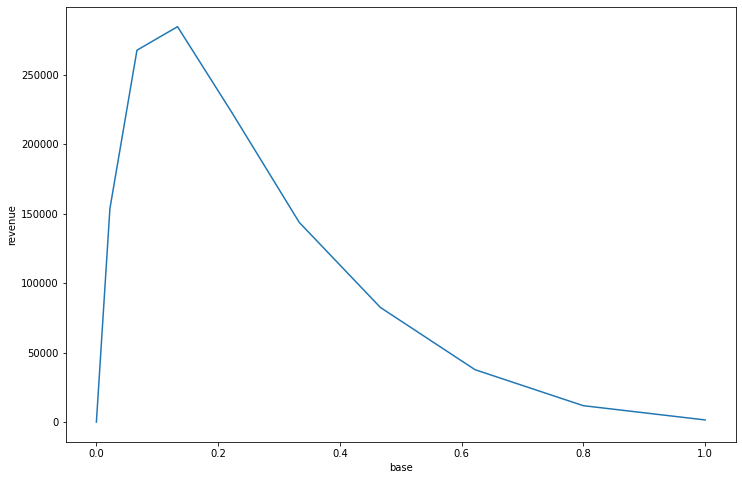

In [ ]:
plt.figure( figsize=(12,8))
aux = df[df['propensity_score'] >= 0.1]
sns.lineplot( x='base', y='revenue', data=aux )

### 7.2 Bussiness analysis